[Importation librairies](#impt)

[Analyses univariées + bivariées](#analyst)
       
[Analyse en composante principale (ACP)](#acp)

[Classification avec Kmeans](#kmeans)

[Modélisation avec la régression logistique](#reglog)

# **`Import des librairies + les paramètres`**<a class="anchor" id="impt"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats  
import seaborn as sns
%matplotlib inline

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from p6Toolbox import *

In [2]:
df = pd.read_csv("notes.csv", sep=",", header=0)

In [3]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


Le jeu de données est structuré comme suit:
- la longueur du billet (en mm) ;
- la hauteur du billet (mesurée sur le côté gauche, en mm) ;
- la hauteur du billet (mesurée sur le côté droit, en mm) ;
- la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- la diagonale du billet (en mm)
- le label (boolean) qui permet de connaitre le type du billet.

In [4]:
## dimensions(nombre d'observation; nombre de variable) du jeu de données
df.shape

(170, 7)

In [5]:
### infos sur les variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [6]:
# Verification s'il y a des valeurs manquantes
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Les données ne contiennent pas de valeur manquante et sont en bon format, nous allons donc passer à l'analyse descriptive.

# **`Analyses univariées + bivariées`**<a class="anchor" id="analyst"></a>

In [7]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


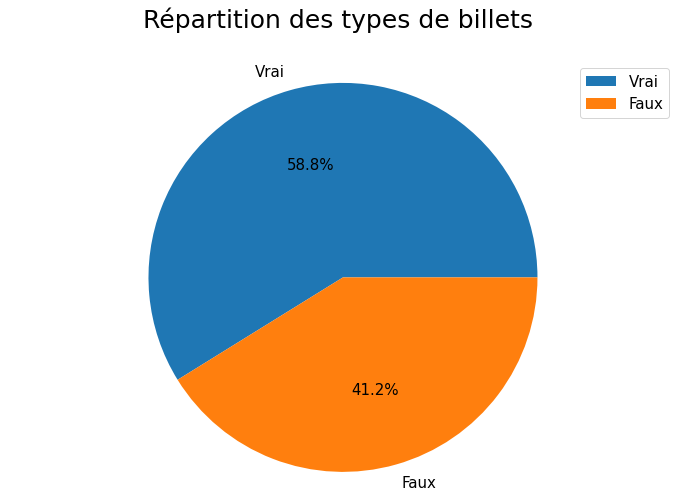

In [8]:
# proportion de faux billets
plt.figure(figsize = (12,8))

plt.pie(df['is_genuine'].value_counts(), labels= ['Vrai', 'Faux'],autopct='%1.1f%%',textprops={'fontsize': 15})
plt.axis('equal')
plt.title('Répartition des types de billets \n', fontsize=25)
plt.legend(fontsize=15);

### Distributions

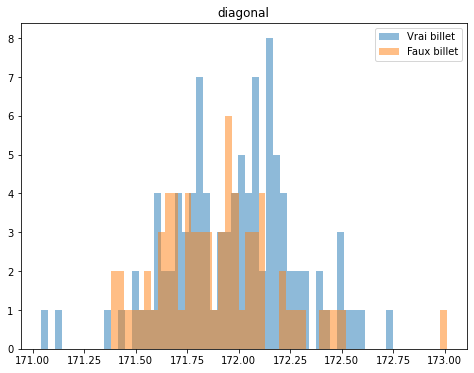

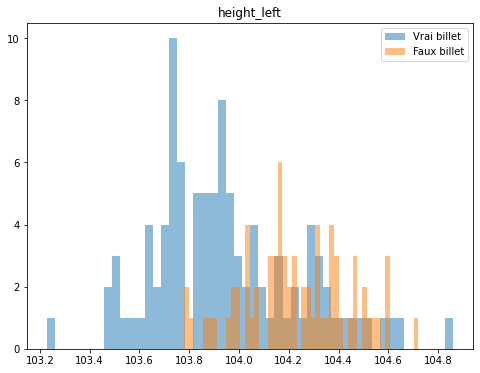

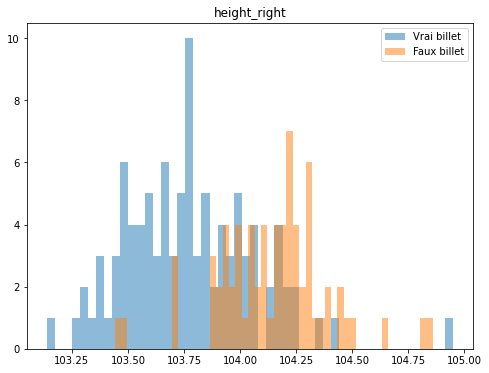

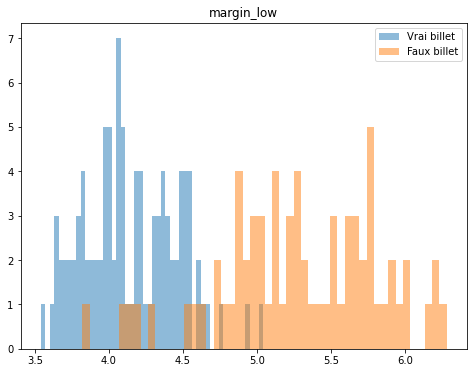

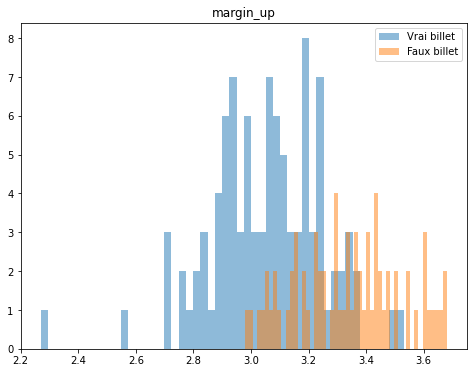

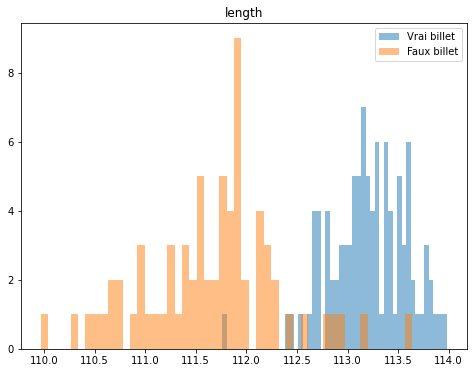

In [9]:
tab = df.iloc[:,1:] # sans la colonne "is_genuine"
for i in tab.columns:
    plt.figure(figsize=(8,6))
    tmp1 = df[df['is_genuine'] == True]
    tmp2 = df[df['is_genuine'] == False]
    plt.hist(tmp1[i], bins=50, alpha=0.5, label="Vrai billet")
    plt.hist(tmp2[i], bins=50, alpha=0.5, label="Faux billet")
    plt.title(i)
    plt.legend(loc='upper right')

On peut observer que les distributions sont légèrement différentes pour chacune des variables en fonction de l'authenticité du billet. C'est le cas pour
- length
- margin_up/low
- height_left/right 
Cependant, les distribuions pour la variable `diagonal` en fonction de `is_genuine` se chevauchent, ce qui pourrait indiquer que cette variable n'est pas pertinente pour distinguer les billets authentiques des faux.

Dans l'ensemble, chaque variable semble être normalement distribuée avec une asymétrie positive et/ou négative. Utilisons les boxplots pour voir si ces valeurs peuvent être considérées comme des valeurs aberrantes ou non.

/home/ldiallo/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


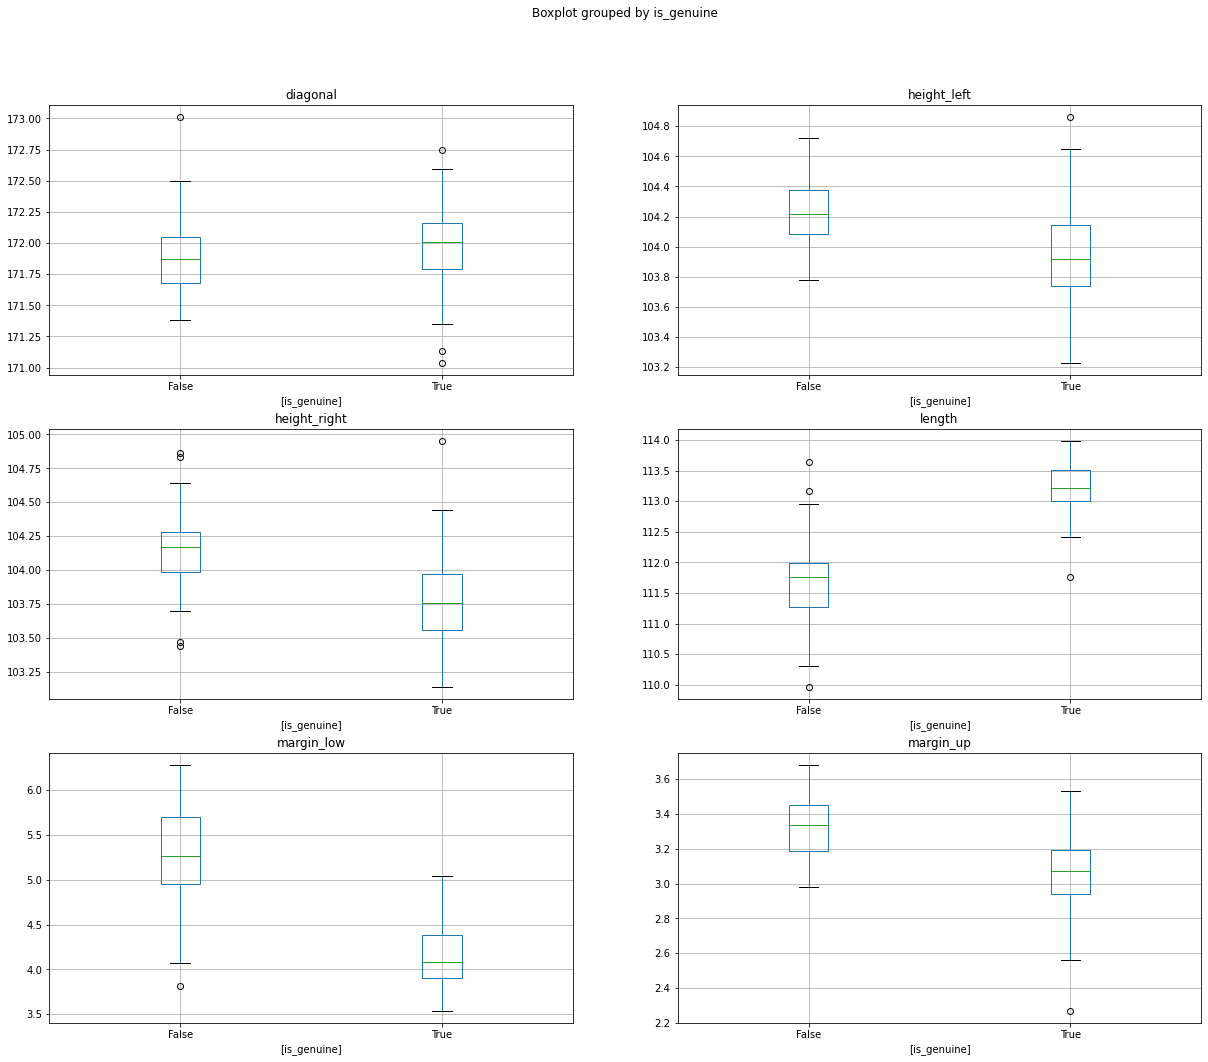

In [10]:
# distribution par type de billets
fig, ax_new = plt.subplots(3,2, sharey=False,figsize=(20,17))
df.boxplot(by="is_genuine",ax=ax_new)
plt.show()

L'analyse de ces graphes montre
- une forte variabilité entre les deux types de billet pour les variables `length`(on voit que les faux billets sont plus court), `mangin_up`, `margin_low` et aussi sur les hauteurs gauche et droite.

Nous pouvons aussi détecter quelques valeurs aberrantes (valeurs extrêmes) dans les deux catégories. Il pourrait être intéressant d'étudier plus en profondeur ces points de données et de voir si oui ou non, nous les gardons dans l'ensemble de données.

En nous reférent sur cet [article](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/), nous allons à présent explorer les outliers que nous venons de voir ci-dessus.

In [11]:
# création d'une fonction pour identifier les outliers pour chaque type de billet
def get_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)] 
    
    return df_out

In [12]:
# Application de la fonction sur la variable "is_genuine"
df.groupby('is_genuine').apply(get_outliers).reset_index(drop=True)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,False,172.32,104.60,104.83,4.84,3.51,112.55
1,False,171.83,104.39,104.17,5.51,3.33,113.64
2,False,172.29,104.72,104.86,5.71,3.16,112.15
3,False,171.74,103.96,103.47,5.14,3.30,111.40
4,False,171.95,104.47,104.34,5.92,3.10,113.17
5,False,171.68,103.89,103.70,5.97,3.03,109.97
6,False,171.67,103.79,103.44,5.13,3.32,111.47
7,False,172.50,104.07,103.71,3.82,3.63,110.74
8,False,173.01,104.59,104.31,5.04,3.05,110.91
9,True,171.81,104.86,104.95,4.52,2.89,112.83


Le tableau montre 14 outliers, dont
- 8 pour les faux billets
- 6 pour les vrais

Nous allons les conserver pour la suite de l'analyse.

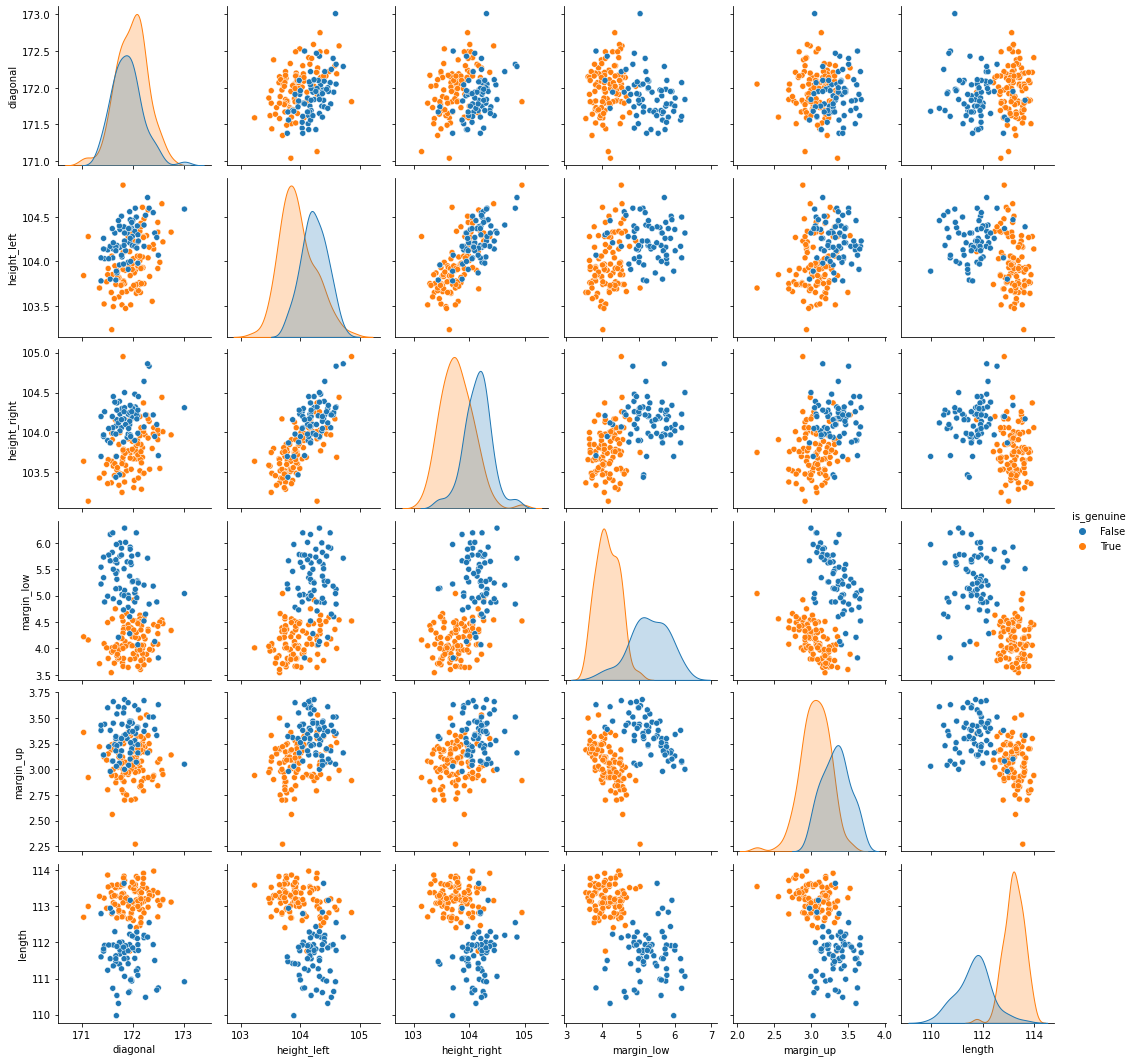

In [13]:
sns.pairplot(df, hue="is_genuine")
plt.show()

Nous pouvons faire les observations suivantes:
- `height_left` & `height_right`:
    - semblent être corrélées l'une à l'autre
    - semblent être positivement corrélées à `margin_up` et`margin_low`
    - semblent être corrélées négativement à la longueur.
    
- `margin_low` & `margin_up`:
    - semblent être corrélées négativement à la longueur
    - semblent être positivement corrélées à la hauteur (à gauche et à droite) 
    - ne semblent pas être corrélées entre elles
  
- `diagonal`:
    - ne semble pas être correlée à une autre variable

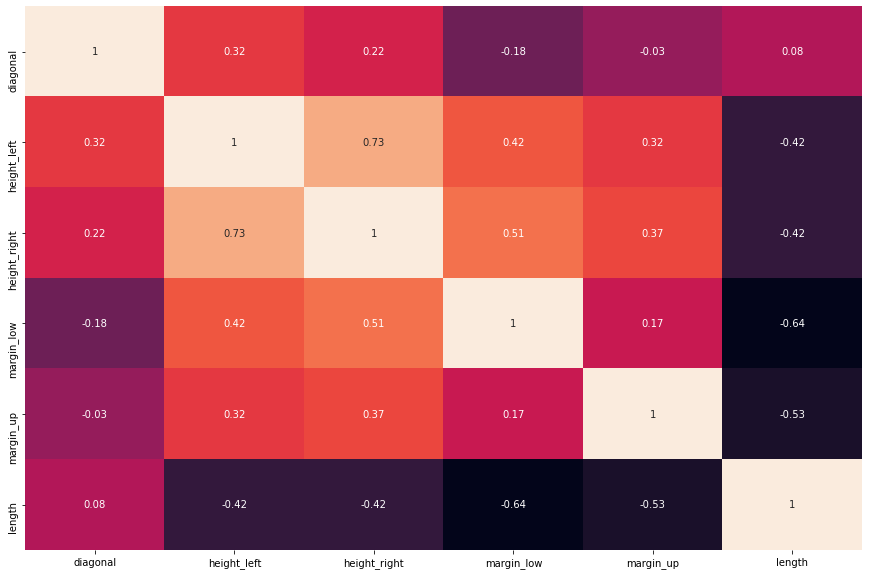

In [14]:
## matrice de corrélation
fig = plt.figure(figsize=(15, 10))
sns.heatmap(df.iloc[:,1:].corr().round(2), annot=True, cbar=False);

Toutes les observations précédentes basées sur les diagrammes en paires sont visibles et vérifiées sur la matrice de corrélation. En outre, nous pouvons voir que le coefficient de corrélation entre la variable `diagonal` et la colonne d'étiquettes `is_genuine` est très faible. Cela indique (une fois de plus), que la variable diagonale n'est pas pertinente pour savoir si un billet est authentique ou non. 

Nous décidons d'abandonner cette variable (`diagonal`) avant de passer à l'étape suivante : l'ACP.

In [15]:
# suppression de la variable 'diagonal'
df_sd = df.drop(['diagonal'],axis=1).copy()

# **`Analyse en composante principale (ACP)`**<a class="anchor" id="acp"></a>

### Centrage et reduction

Toutes les variables du jeu données sont exprimées dans les mêmes unités : les millimètres. Néanmoins, la mise à l'échelle des variables est essentielle avant d'appliquer l'ACP car la gamme varie légèrement entre les caractéristiques.

Par exemple :
- `margin_low` varie entre **0,2** et **6**
- `height_left` varie entre **103** et **104**

Par conséquent, même si toutes les unités sont exprimées dans les mêmes unités, les variables marges(_margin\_low_ et _margin\_low_) peuvent peser moins dans le modèle que les autres. Les procédures de normalisation des données permet de corriger cette différence.

In [16]:
# fonction pour centrer & reduire
def standard(df, idxcol):
    df_std = df.copy()
    df_std = df_std.set_index(idxcol)
    mask = df_std.columns
    df_std[mask] = StandardScaler().fit_transform(df_std[mask])

    return df_std

In [17]:
Z = standard(df_sd,'is_genuine').reset_index() 

In [18]:
# on extrait les noms des variables ainsi que la variable `is_genuine`
colonne = Z.iloc[:,1:].columns
y =  Z['is_genuine'].values #labels

In [19]:
# instanciation
acp = PCA()
comp = ['PC1','PC2','PC3','PC4','PC5']

df_acp = Z[['is_genuine']].copy()
df_acp[comp] = pd.DataFrame(acp.fit_transform(Z.iloc[:,1:].values),columns=[comp])

In [20]:
df_acp.head()

,is_genuine,PC1,PC2,PC3,PC4,PC5
0,True,2.143117,2.982124,-1.947397,0.221265,-0.948574
1,True,-2.051636,0.411908,0.249463,-0.029359,-0.463753
2,True,-1.953085,0.808068,0.247236,-0.544796,0.059205
3,True,-2.035150,-0.359593,-0.537573,-0.181211,0.010054
4,True,-2.432789,2.792122,1.962433,-0.133434,-0.572201


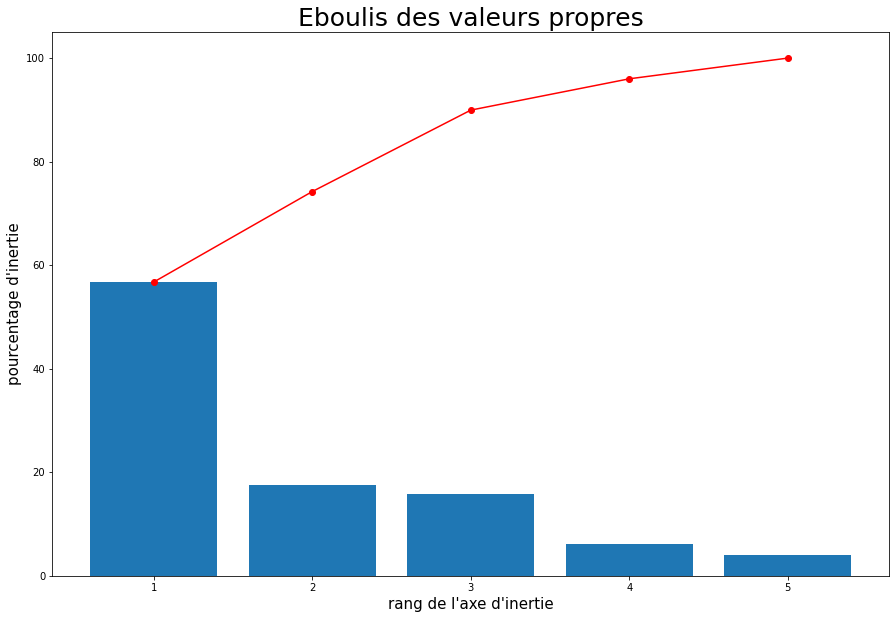

In [21]:
# Eboulis des valeurs propres
fig = plt.figure(figsize=(15, 10))
display_scree_plot(acp)

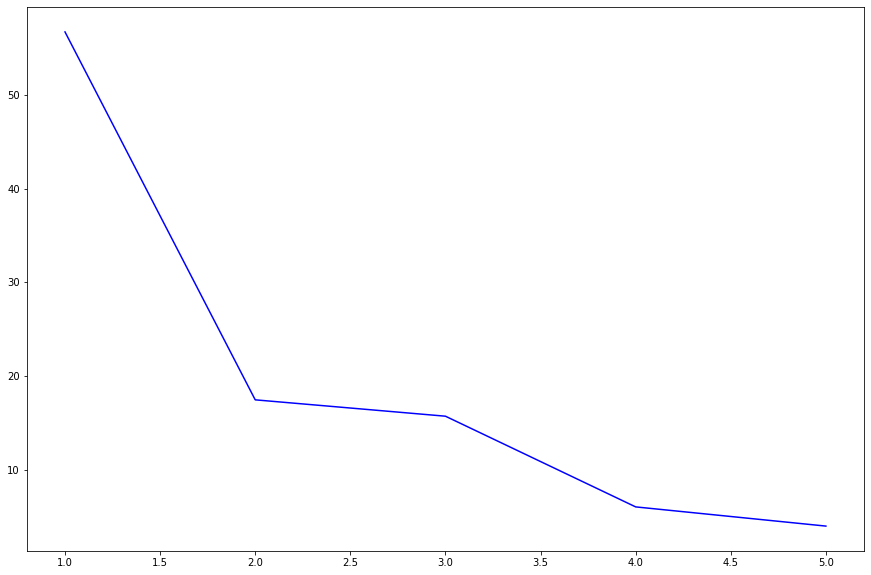

In [22]:
# Focus sur l'eboulis
fig = plt.figure(figsize=(15, 10))
scr = acp.explained_variance_ratio_*100
plt.plot(np.arange(len(scr))+1, scr,c="blue")
plt.show()

In [23]:
#proportion de variance expliquée
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim " + str(x + 1) for x in range(5)], 
        "Variance expliquée" : acp.explained_variance_,
        "% variance expliquée" : np.round(acp.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(acp.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim 1,2.854145,57.0,57.0
1,Dim 2,0.878947,17.0,74.0
2,Dim 3,0.791122,16.0,90.0
3,Dim 4,0.304196,6.0,96.0
4,Dim 5,0.201175,4.0,100.0


Le deux premières composantes capturent `74%` de la variance. Sur la base du screen plot, nous allons garder les trois(3) premières composantes car elles capturent environ 90% de la variance totale.

## Répresentation des variables

In [24]:
n = Z.shape[0]
p = acp.n_components_
eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': Z.columns[1:], 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,height_left,0.787939,0.334649
1,height_right,0.820876,0.318611
2,margin_low,0.741503,0.219989
3,margin_up,0.599752,-0.708835
4,length,-0.795702,0.330803


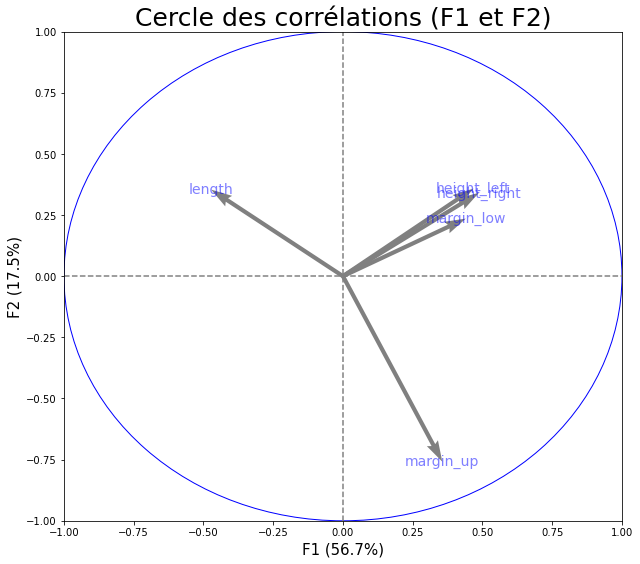

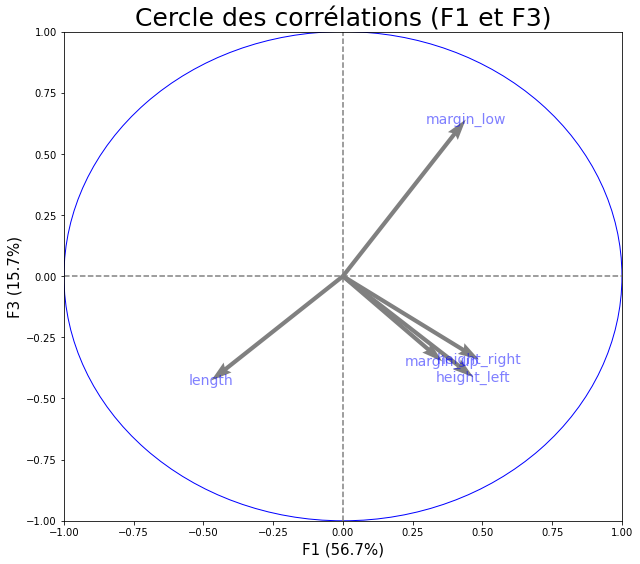

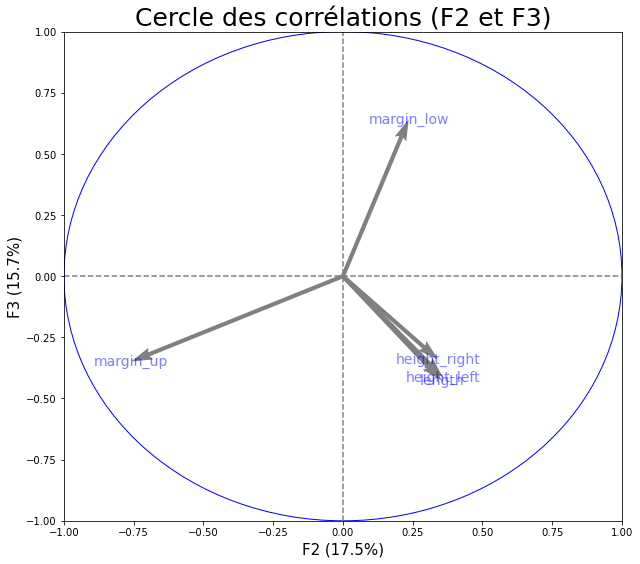

In [25]:
# Cercle des corrélations
n_comp = acp.n_components_
pcs = acp.components_

display_circles(pcs, n_comp, acp, [(0,1),(0,2),(1,2)], labels = np.array(colonne))
plt.show()

- Sur le premier plan factoriel:
    - Toutes les variables semblent peser de manière égale sur le plan `F1`. La variable `length` est la seule qui est négativement corrélée à ce axe.
    - `margin_up` semble peser davantage sur l'axe `F2` que les autres axes. C'est également la seule à être négativement corrélée à cet axe.
   <!-- - `margin_low` semble peser plus sur l'axe `F3` que sur les autres axes. C'est aussi la seule à être corrélé positivement à cet axe. -->

On peut également joindre des analyses faites lors de l'analyse descriptive sur la façon dont les variables sont corrélées entre elles.

   - sur l'axe `F2`:
       - `height_left` et `height_right` sont fortement corrélés entre eux : les deux vecteurs sont proches dans chaque plan.
       - elles sont également fortement corrélées à `margin_low`.
   - Sur l'axe F3 :
       - `height_left` et `height_right` sont fortement corrélés entre eux : les deux vecteurs sont proches dans chaque plan(F1&F3 et F2&F3).
       - elles sont également fortement corrélées à la variable `length` dans le plan factoriel F2 & F3.

## Représentation des individus
Les graphiques de score indiquent la projection des individus sur l'étendue des composantes principales. Comme dans la section précédente, cet ensemble tridimensionnel donne lieu à trois diagrammes de score, un pour chaque combinaison de composante par paire. Nous utilisons le champ `is_genuine` comme étiquette pour nos données afin de voir si nous pouvons détecter un modèle dans les 3 différentes combinaisons de composantes.

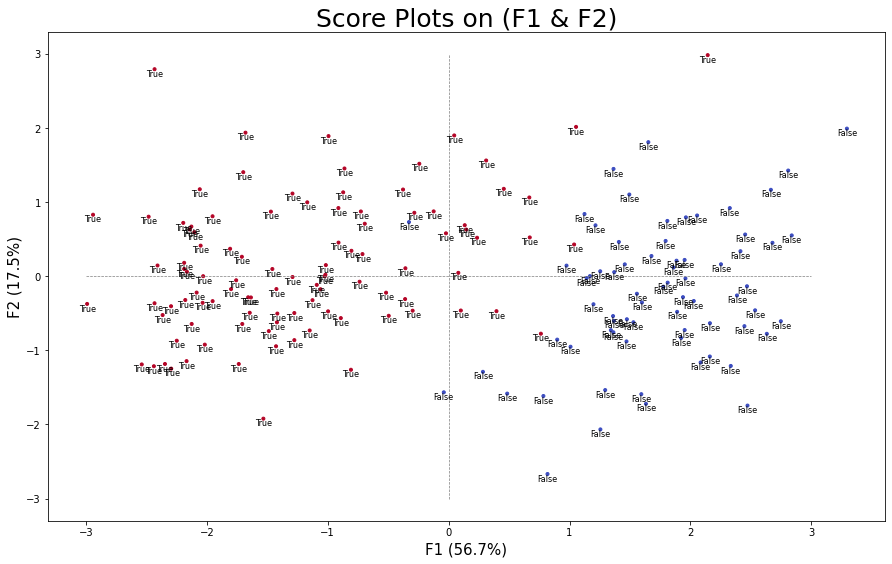

In [26]:
# Creating the score plots for the dataset : F1 vs F2
display_score_plot(df_acp.iloc[:,1:].values, 3, acp, [(0,1)], labels=y, marker='.')

La séparation entre les 2 groupes de billets est très nette et claire sur le plan factoriel.

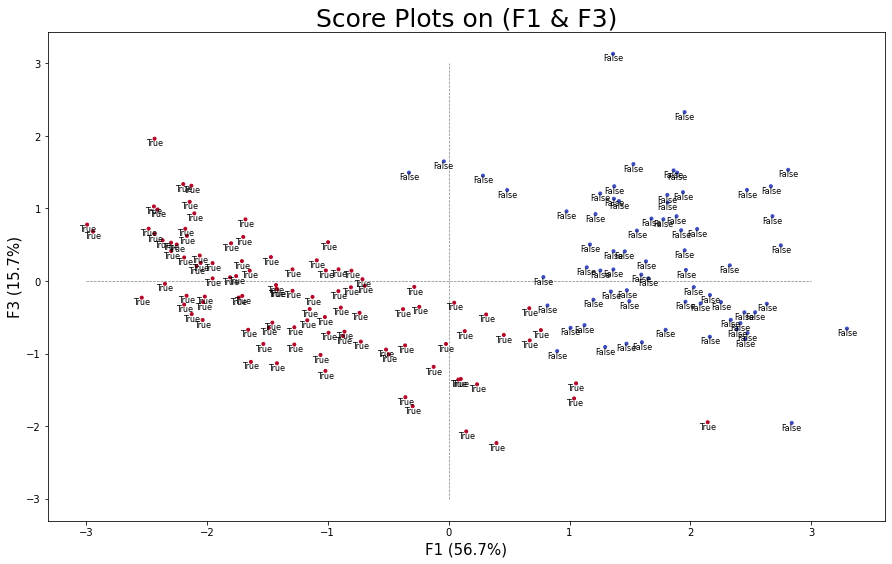

In [27]:
# Creating the score plots for the dataset : F1 vs F3
display_score_plot(df_acp.iloc[:,1:].values, 3, acp, [(0,2)], labels=y, marker='.')

Mêmes observations que précédemment : la séparation entre les 2 groupes est relativement nette sur le plan factoriel. Pour chaque groupe, les points sont moins dispersés sur l'axe F3 que sur l'axe F2.

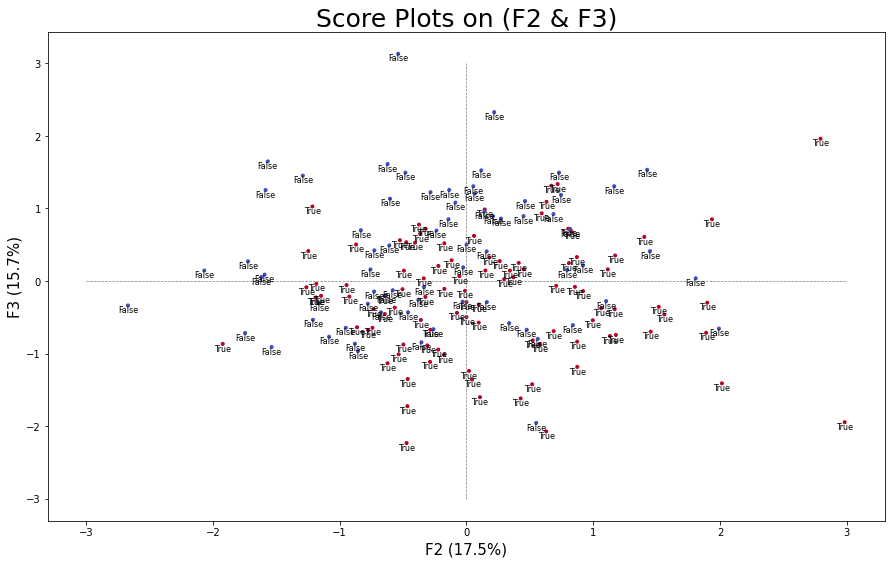

In [28]:
# Creating the score plots for the dataset : F2 vs F3
display_score_plot(df_acp.iloc[:,1:].values, 3, acp, [(1,2)],labels=y, marker='.')

Ce plan factoriel(F2&F3 qui capture _33.2%_ de la variance totale) n'est pas le meilleur pour visualiser les 2 groupes et différencier les vrais billets des faux.
<!--Les points de données sont regroupés autour du centre du graphique et mélangés entre eux. -->

## Analyses de la qualité de représentation et la contribution des individus

Pour calculer la qualité de représentation des individus sur les axes, nous devons d’abord calculer les carrés des
distances à l’origine des individus, qui correspondent également à leur contribution dans l’inertie totale.

In [29]:
#contribution des individus dans l'inertie totale
Z_projected = acp.fit_transform(Z)
di = np.sum(Z_projected**2,axis=1)
pd.DataFrame({'ID':Z.index,'d_i':di}).sort_values(by='d_i', ascending=False)

,ID,d_i
0,0,18.396669
4,4,18.080320
122,122,15.823398
151,151,13.252690
112,112,13.219616
...,...,...
83,83,1.401689
85,85,1.327802
52,52,1.303873
64,64,0.957210


On voit que les individus `0`(le premier individu), `4` et `122` sont ceux qui se demarquent le plus des autres.

In [30]:
#qualité de représentation des individus - COS2
cos2 = Z_projected**2
for j in range(5):
    cos2[:,j] = cos2[:,j]/di
    
print(pd.DataFrame({'id':Z.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

      id    COS2_1    COS2_2
0      0  0.198212  0.634644
1      1  0.905434  0.020329
2      2  0.798179  0.097816
3      3  0.906002  0.018365
4      4  0.334485  0.292432
..   ...       ...       ...
165  165  0.822768  0.038364
166  166  0.657934  0.092992
167  167  0.711718  0.098487
168  168  0.232687  0.719159
169  169  0.481191  0.142727

[170 rows x 3 columns]


### Contribution des individus aux axes 
Elles permettent de déterminer les individus qui pèsent le plus dans la définition de chaque facteur.

In [31]:
#contributions aux axes
ctr = Z_projected**2
for j in range(p):
    ctr[:,j] = ctr[:,j]/(n*eigval[j])

In [32]:
# les 5 individus les plus determinant du 1er axe
pd.DataFrame({'id':Z.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}).sort_values(by='CTR_1', ascending=False).head(5)

,id,CTR_1,CTR_2
122,122,0.022661,0.030656
49,49,0.018419,0.002418
29,29,0.018054,0.002420
158,158,0.017133,0.009118
112,112,0.016966,0.006009


Pour le premier axe, l'individu `122` est le plus determinant.

In [33]:
# les 5 individus les plus determinant pour le 2ème axe
pd.DataFrame({'id':Z.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}).sort_values(by='CTR_2', ascending=False).head(5)

,id,CTR_1,CTR_2
0,0,0.007560,0.078600
160,160,0.001904,0.044323
5,5,0.001585,0.036349
4,4,0.012538,0.035594
122,122,0.022661,0.030656


Ici, on observe que les `5` individus les plus determinant pour le deuxième axe sont **`0`**, **`4`**, **`160`**, **`122`** et **`5`**.

# **`Classification`**<a class="anchor" id="kmeans"></a>

Nous allons utiliser l'algorithme des **$\mathcal{k}$-means** pour faire le clustering.

In [34]:
# 2 types de billets ==> n_cluster = 2
km = KMeans(n_clusters=2,init='k-means++',max_iter=300, n_init=10, random_state=42) 

km.fit(Z.iloc[:,1:].values)
y_km = km.predict(Z.iloc[:,1:].values)
Z['cluster'] = km.labels_

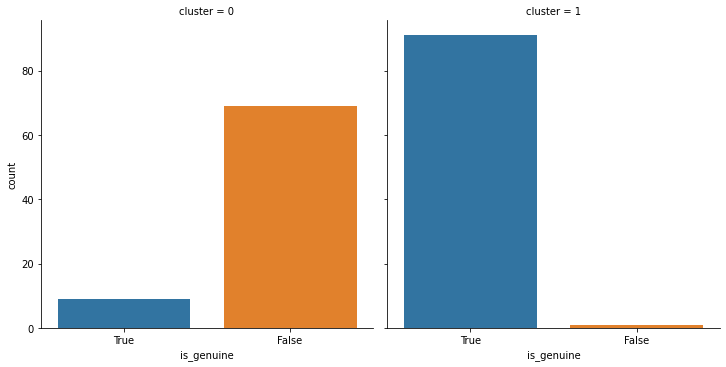

In [35]:
# voyons voir la distribution de chaque type de billet avec les clusters
sns.catplot(col='cluster', y=None, x='is_genuine', data=Z, kind='count', order=[True,False]);

On peut voir que certains individus ont été mal étiquetés :
- le `cluster 0` est principalement composé de faux billets. Cependant, environ **10** billets authentiques ont été placés dans ce cluster.
- réciproquement pour le `cluster 1`, mais avec une meilleure précision car le nombre de points de données mal étiquetés est très faible.

Regardons de plus près la structure de ces points de données et essayons de comprendre pourquoi ils ont été mal étiquetés par l'algorithme **$\mathcal{k}$-means**.

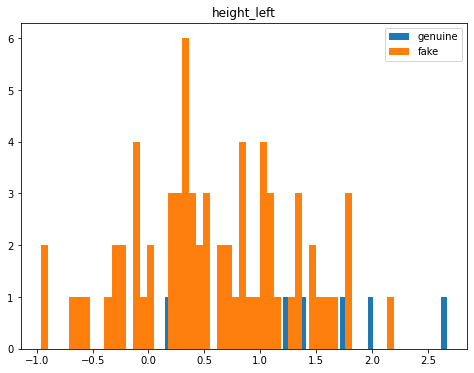

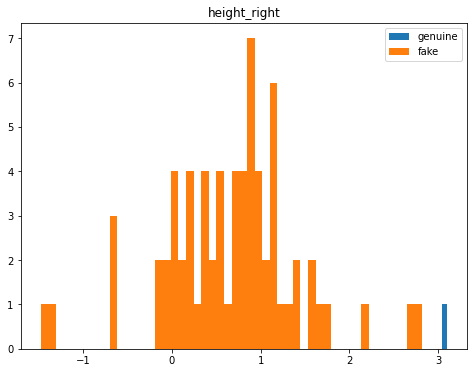

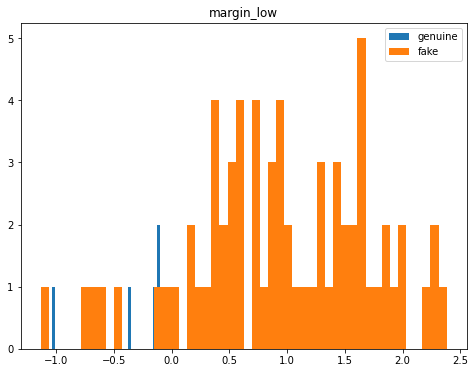

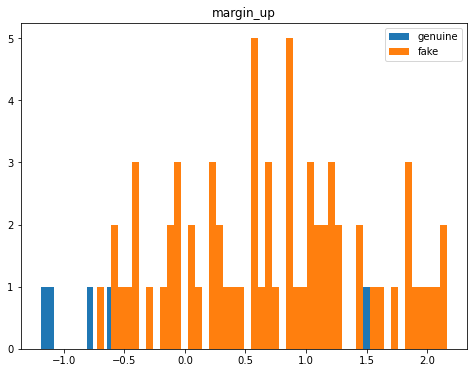

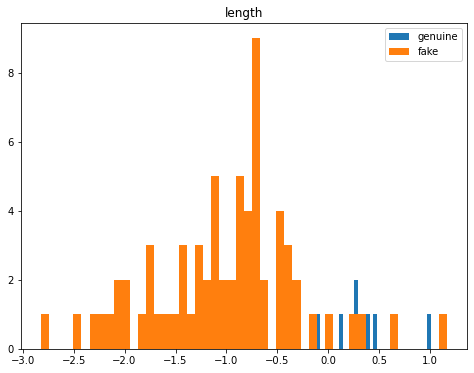

In [36]:
# extraction sur le cluster 0
df_cl = Z[Z['cluster'] == 0]
tmp = df.iloc[:,2:] # sans la variable `is_genuine`

# voir la distribution pour chacune des colonnes
for i in tmp.columns:
    plt.figure(figsize=(8,6))
    tmp1 = df_cl[df_cl['is_genuine'] == True]
    tmp2 = df_cl[df_cl['is_genuine'] == False]
    plt.hist(tmp1[i], bins=50, label="genuine")
    plt.hist(tmp2[i], bins=50, label="fake")
    plt.title(i)
    plt.legend(loc='upper right')

On constate que 
- la distribution des variables `height_left & height_right` se chevauchent pour les 2 catégories - sauf un point (authentique) qui est clairement à la limite droite de la distribution.
- il en va de même pour la variable `margin_up`, avec quelques points (authentiques) au bord gauche de la distribution.
- Pour les deux autres variables, la distribution des points étiquetés comme authentiques se chevauche avec la queue de droite (longueur) et la queue de gauche (`margin_low`).

En d'autres termes, ces points de données (authentiques) ont été placés dans le groupe des faux, car leur hauteur et leur `margin_up` sont proches des caractéristiques du groupe des faux. Et parce que, parmi le groupe de faux, il y a quelques points avec des valeurs extrêmes pour la longueur et la marge_bas qui les font ressembler beaucoup à un billet authentique.

In [37]:
# extraction sur le cluster 1
df1 = Z[Z['cluster'] == 1]
# sans la variable `is_genuine`
tmp = df1.iloc[:,1:-1] 

fak = Z[(Z['is_genuine'] == False) & (Z['cluster'] == 1)]
len(fak)

1

Un seul billet a été placé dans le groupe des authentiques, alors qu'il s'agissait en fait d'un faux billet.

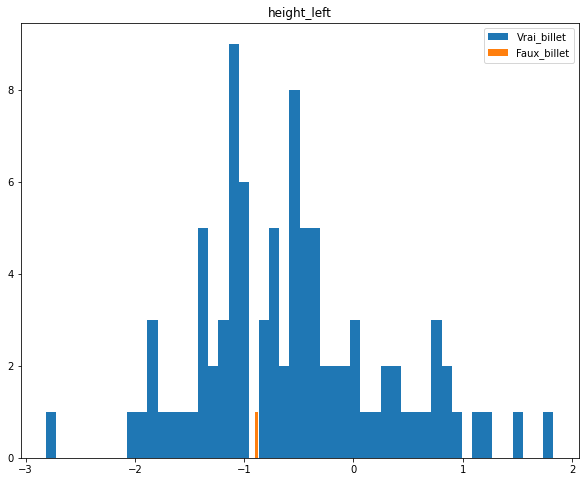

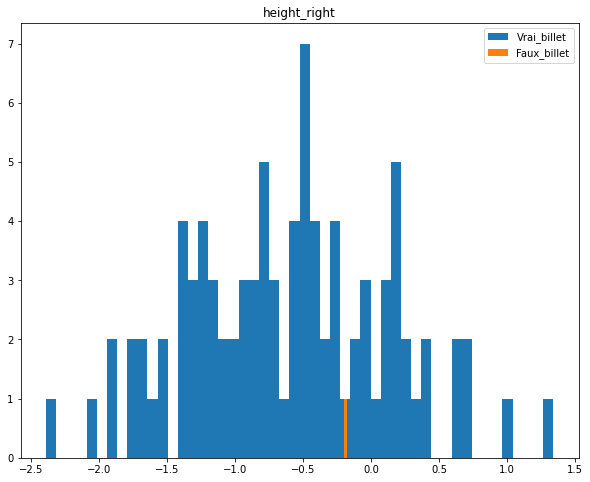

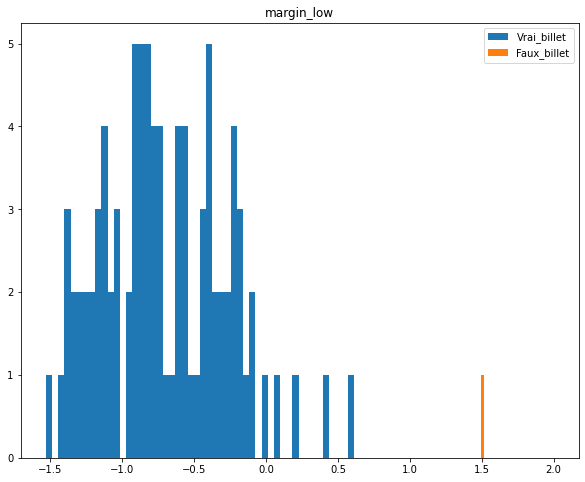

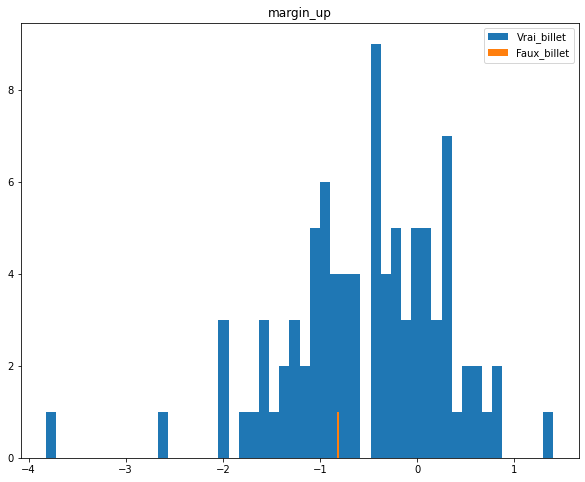

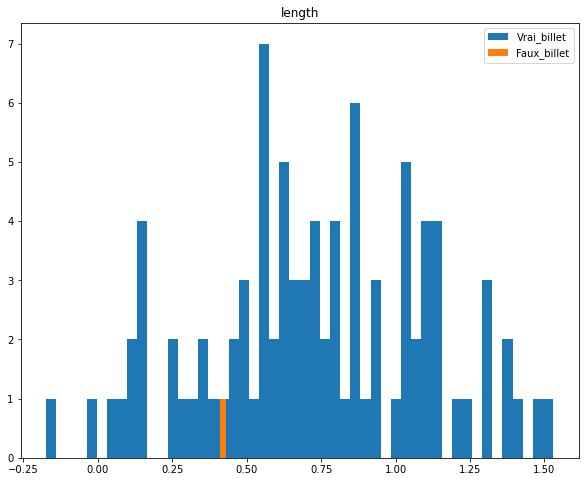

In [38]:
# distribution pour chacune des colonnes
for i in tmp.columns:
    plt.figure(figsize=(10,8))
    tmp1 = df1[df1['is_genuine'] == True]
    tmp2 = df1[df1['is_genuine'] == False]
    plt.hist(tmp1[i], bins=50, label="Vrai_billet")
    plt.hist(tmp2[i], bins=50, label="Faux_billet")
    plt.title(i)
    plt.legend(loc='upper right')

Ce billet a été mal étiqueté parce qu'il ressemble à un véritable billet en ce qui concerne toutes les variables, sauf pour la variable `margin_low`, pour laquelle sa valeur est clairement hors de la distribution normale.

Nous allons visualiser les resultats du k-means dans un _scatter plot_.

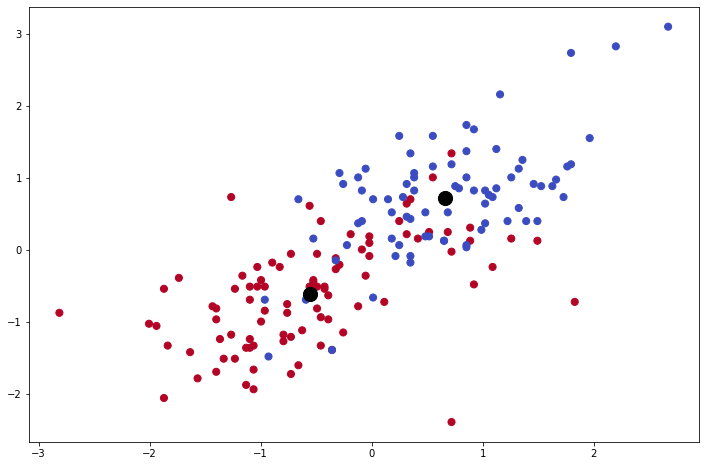

In [39]:
tmp = np.array(Z.iloc[:,1:-1])
plt.figure(figsize = (12,8))
plt.scatter(tmp[:,0], tmp[:,1], c=y_km, s=50, cmap='coolwarm') 

# Visualiser aussi les centroïdes de chaque cluster 
centers = km.cluster_centers_ 
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

#### Projection dans le premier plan factoriel

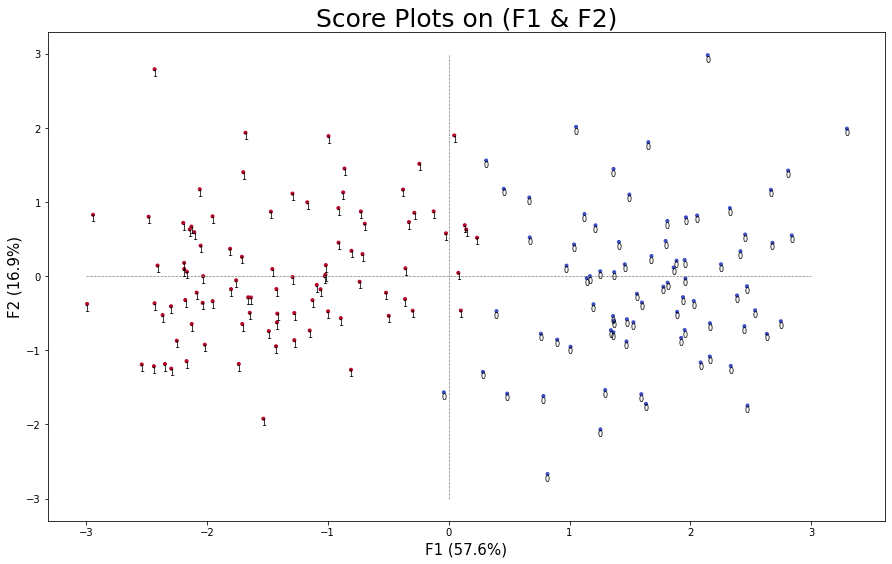

In [40]:
# ajout des clusters dans la table résultante de l'ACP
clus = Z.iloc[:,-1]
df_acp = df_acp.join(clus)

display_score_plot(df_acp.iloc[:,1:].values, 3, acp, [(0,1)], labels=df_acp['cluster'], marker='.') 

On peut voir que 
- les deux groupes sont bien séparés dans le plan factoriel
- certains points ont des valeurs extrêmes (au-dessus du 0 sur l'axe des x) et sont en fait plus proches de l'autre groupe. 

Faisons le même graphe mais avec l'étiquette réelle vs les clusters trouvés par les k-means pour illustrer les performances.

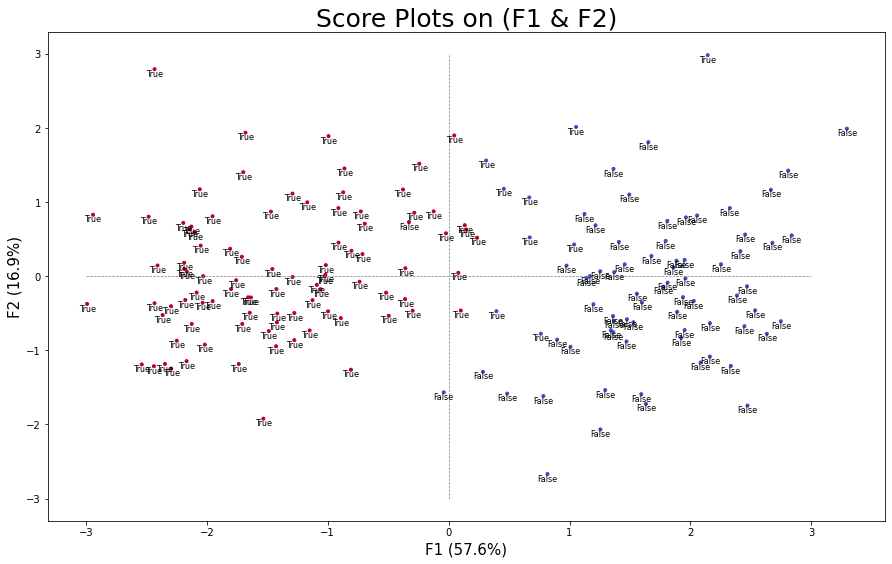

In [41]:
display_score_plot2(df_acp.iloc[:,1:].values, 3, acp, [(0,1)], labels=y, cluster= df_acp['cluster'],marker='.')

Cette visualisation est intéressante pour représenter la précision du résultat du K-means.
- les vrais billets sont normalement en rouge.
- On peut voir que certains d'entre eux, à la limite des 2 groupes et dans le coin supérieur droit sont en bleu, donc dans le mauvais cluster.
    - Ceci peut s'expliquer par un manque de sensibilité de l'algorithme (pour ceux à la limite des 2 groupes)
    - ou par des valeurs anormales pour le point de données dans le coin supérieur droit.

# **`Régression logistique`** <a class="anchor" id="reglog"></a>

In [42]:
# Comme précédemment, nous n'allons pas conserver la variable 'diagonale'
features = df.iloc[:,2:] 
labels =  df['is_genuine']

features.head()

,height_left,height_right,margin_low,margin_up,length
0,104.86,104.95,4.52,2.89,112.83
1,103.74,103.70,4.01,2.87,113.29
2,103.76,103.76,4.40,2.88,113.84
3,103.78,103.65,3.73,3.12,113.63
4,103.70,103.75,5.04,2.27,113.55


In [43]:
# Partage du jeu de donnée en "apprentissage" et "test"
    # nous allons appliquer un ratio de 80 / 20
    # Nous procédons à une stratification sur la base de la colonne is_genuine afin de conserver la proportion de faux billets et de billets authentiques dans les deux ensembles.
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify = labels, test_size=0.2) 

In [44]:
# dimensions des données
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(136, 5) (34, 5) (136,) (34,)


In [45]:
## Application de l'algo
# sur les données d'apprentissage
model = LogisticRegression(random_state=42)
rl = model.fit(X_train, y_train)

In [46]:
# Faire une prediction sur les données "test"
y_pred = rl.predict(X_test)

Nous allons stocker les résultats ainsi que les probabilités associées dans un _DataFrame_.

In [47]:
res = X_test.copy()
res['proba_Faux'] = rl.predict_proba(X_test)[:,0]
res['proba_Vrai'] = rl.predict_proba(X_test)[:,1]
res['prediction'] = rl.predict(X_test)
res.head()

,height_left,height_right,margin_low,margin_up,length,proba_Faux,proba_Vrai,prediction
111,104.40,104.21,5.28,3.41,112.11,0.940874,0.059126,False
142,104.18,104.28,5.62,3.23,110.53,0.998594,0.001406,False
30,104.05,103.81,3.90,3.22,113.52,0.009924,0.990076,True
35,104.17,104.16,4.75,2.94,113.52,0.088201,0.911799,True
107,104.05,104.30,5.02,3.44,112.01,0.903184,0.096816,False


#### Performance du modele
- Performance réelle :

In [48]:
# Calcul de la performance sur les données d'apprentissage
score = rl.score(X_train, y_train)
print(score)

0.9852941176470589


- Performance prédictive :

In [49]:
# Calcul de la performance sur les données test
score = rl.score(X_test, y_test)
print('Nous obtenons une performance prédictive de {}'.format(score))

Nous obtenons une performance prédictive de 0.9411764705882353


In [50]:
# voir les stats()
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.93      0.93        14
        True       0.95      0.95      0.95        20

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34



#### Matrice de confusion

In [51]:
mc = metrics.confusion_matrix(y_test, y_pred)
print(mc)

[[13  1]
 [ 1 19]]


In [52]:
# Zoom sur les deux faux negatifs
# Extraction des données sur le "test" et la "prediction"
test = pd.Series(y_test.reset_index().iloc[:,1],name='test')
pred = pd.Series(y_pred,name='predictions')

# un nouveau DataFrame pour les infos
tp = pd.concat([test, pred], axis=1)

# les lignes ou il n'y a pas de correspondance
tp[tp['test'] != tp['predictions']]

,test,predictions
8,False,True
16,True,False


## Algorithme de prédiction

In [53]:
def detecteur_faux_billets(df):
    
    #Read the data
    df.drop(columns =['diagonal'],axis=1, inplace=True)
    df_rl = df.set_index('id').copy()
    
    # Prediction
    results = df_rl.copy()
    results['proba_Faux'] = rl.predict_proba(df_rl)[:,0]
    results['proba_Vrai'] = rl.predict_proba(df_rl)[:,1]
    results['prédit_Vrai'] = rl.predict(df_rl)
    
    return results[['proba_Faux','proba_Vrai','prédit_Vrai']]

In [54]:
exemple = pd.read_csv("example.csv")

In [55]:
detecteur_faux_billets(exemple)

,proba_Faux,proba_Vrai,prédit_Vrai
id,,,
A_1,0.936428,0.063572,False
A_2,0.984659,0.015341,False
A_3,0.967419,0.032581,False
A_4,0.143708,0.856292,True
A_5,0.005172,0.994828,True
